# Perform Uncertainty analysis on gauge height data

## Here is an implementation of LSTM with dropout as an uncertainty estimation method. 

### Data was obtained from USGS waterdata (https://waterdata.usgs.gov/usa/nwis/uv?07019130)

In [18]:
# import all the required libraries

import numpy
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from keras.layers.core import Lambda
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM

In [19]:
# Import Water levels data in Valley Park, MO on the Meramac river
df = pd.read_excel ('Valleypark.xlsx')

# Selecting the values after 1996 as they have 15 min recordings
df = df[:-143441]  

# Convert string data to float
df = df.astype(float)   

In [20]:
# Define premanent dropout to retain dropout for the predictions
# For more information refer (https://github.com/keras-team/keras/issues/1606)

def PermaDropout(rate):
    return Lambda(lambda x: K.dropout(x, level=rate))

In [21]:
# Create the experiment

def experiment(data):
    # Removing NAN values
    data = x = np.array(data)[~numpy.isnan(np.array(data))]
    data = pd.DataFrame(data)
    
    
    
    # Normalizing data
    dataset = numpy.reshape(data, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    
    
    # Split into training and testing data (80/20)
    train_size = int(len(dataset) * 0.80)
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    
    
    
    # Function for creating lookback data
    def create_dataset(dataset, look_back=1):
        X, Y = [], []
        for i in range(len(dataset) - look_back - 1):
            a = dataset[i:(i + look_back), 0]
            X.append(a)
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)
    
    

    # Defining lookback to create training and testing data for LSTM
    look_back = 100
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)
    
    
    
    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    
    
    
    # LSTM model with 1 LSTM unit, Dropout layer and Dense Layer
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(PermaDropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse']) 
    
    
    history = model.fit(X_train, Y_train, epochs=2, batch_size=1000, validation_split=0.33,
                    verbose=1, shuffle=False)
    model.summary()
    
    
    
    # Predictions from the model
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    # invert predictions
    train_predict = scaler.inverse_transform(train_predict)
    Y_train = scaler.inverse_transform([Y_train])
    test_predict = scaler.inverse_transform(test_predict)
    Y_test = scaler.inverse_transform([Y_test])
    
    
    
    # Save the model for future use
    from keras.models import model_from_json
    # serialize model to JSON
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("model.h5")
    
    
    
    # Print performance metrics for each epoch
    print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
    print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
    print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
    print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
    
    
    
    # shift train predictions for plotting
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
    # shift test predictions for plotting
    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()
    
    
    
    # Store performance metrics
    acc= []
    acc.append(mean_absolute_error(Y_train[0], train_predict[:,0]))
    acc.append(np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
    acc.append(mean_absolute_error(Y_test[0], test_predict[:,0]))
    acc.append(np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
    
    
    
    # Create input sample for out-of-sample predictions
    newtest = X_test
    newtest = np.split(newtest, len(newtest))
    sample = newtest[len(newtest) - 1]
    
    
    
    # Make new predictions -- > 584 new samples predicted in this scenario 
    no_predictions = 584
    
    data_results = []
    
    for x in range(no_predictions):
        pred = model.predict(sample)
        sample = np.delete(sample, 0, axis=2)
        sample = np.append(sample, pred)
        sample = np.array([[list(sample)]])
        scaler.inverse_transform(pred)
        data_results.append(pred)
        
    data_results = numpy.concatenate( data_results, axis=0 )
    data_results = scaler.inverse_transform(data_results)
    
    
    
    # Return the test, out-of sample predictions and performance metrics
    return test_predict,data_results, acc

iteration
0
Train on 61065 samples, validate on 30078 samples
Epoch 1/2
61065/61065 [==============================] - 3s 56us/step - loss: 0.0022 - mean_absolute_error: 0.0297 - mean_squared_error: 0.0022 - val_loss: 0.0014 - val_mean_absolute_error: 0.0187 - val_mean_squared_error: 0.0014
Epoch 2/2
61065/61065 [==============================] - 5s 86us/step - loss: 0.0041 - mean_absolute_error: 0.0429 - mean_squared_error: 0.0041 - val_loss: 0.0010 - val_mean_absolute_error: 0.0188 - val_mean_squared_error: 0.0010
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
lambda_3 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 80

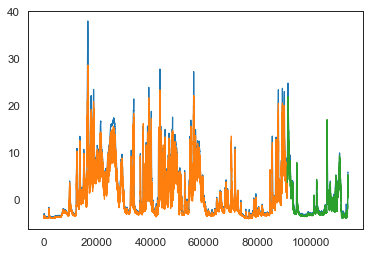

iteration
1
Train on 61065 samples, validate on 30078 samples
Epoch 1/2
61065/61065 [==============================] - 4s 59us/step - loss: 0.0027 - mean_absolute_error: 0.0315 - mean_squared_error: 0.0027 - val_loss: 0.0018 - val_mean_absolute_error: 0.0264 - val_mean_squared_error: 0.0018
Epoch 2/2
61065/61065 [==============================] - 1s 21us/step - loss: 0.0033 - mean_absolute_error: 0.0374 - mean_squared_error: 0.0033 - val_loss: 4.9642e-04 - val_mean_absolute_error: 0.0115 - val_mean_squared_error: 4.9642e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
lambda_4 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total pa

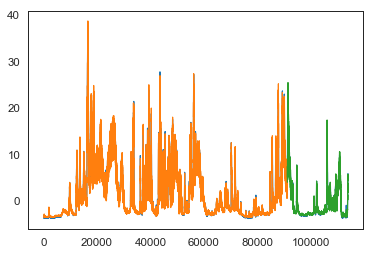

iteration
2
Train on 61065 samples, validate on 30078 samples
Epoch 1/2
61065/61065 [==============================] - 5s 84us/step - loss: 0.0027 - mean_absolute_error: 0.0319 - mean_squared_error: 0.0027 - val_loss: 0.0011 - val_mean_absolute_error: 0.0182 - val_mean_squared_error: 0.0011
Epoch 2/2
61065/61065 [==============================] - 2s 25us/step - loss: 0.0028 - mean_absolute_error: 0.0339 - mean_squared_error: 0.0028 - val_loss: 6.1937e-04 - val_mean_absolute_error: 0.0126 - val_mean_squared_error: 6.1937e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
lambda_5 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total pa

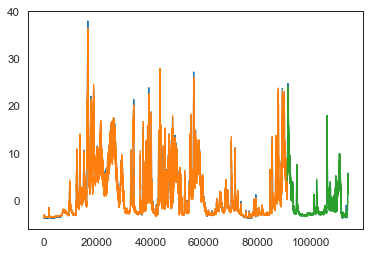

iteration
3
Train on 61065 samples, validate on 30078 samples
Epoch 1/2
61065/61065 [==============================] - 4s 72us/step - loss: 0.0023 - mean_absolute_error: 0.0294 - mean_squared_error: 0.0023 - val_loss: 3.3259e-04 - val_mean_absolute_error: 0.0086 - val_mean_squared_error: 3.3259e-04
Epoch 2/2
61065/61065 [==============================] - 1s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0202 - mean_squared_error: 0.0011 - val_loss: 0.0010 - val_mean_absolute_error: 0.0225 - val_mean_squared_error: 0.0010
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
lambda_6 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total pa

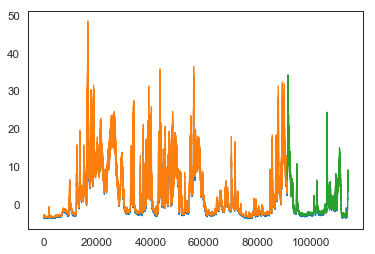

iteration
4
Train on 61065 samples, validate on 30078 samples
Epoch 1/2
61065/61065 [==============================] - 10s 172us/step - loss: 0.0014 - mean_absolute_error: 0.0223 - mean_squared_error: 0.0014 - val_loss: 2.7003e-04 - val_mean_absolute_error: 0.0117 - val_mean_squared_error: 2.7003e-04
Epoch 2/2
61065/61065 [==============================] - 2s 34us/step - loss: 7.0202e-04 - mean_absolute_error: 0.0165 - mean_squared_error: 7.0202e-04 - val_loss: 5.3474e-04 - val_mean_absolute_error: 0.0162 - val_mean_squared_error: 5.3474e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
lambda_7 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1

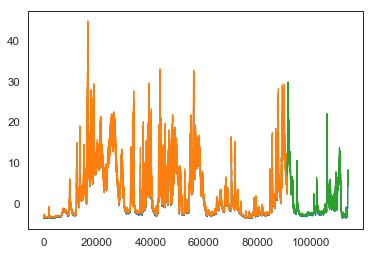

iteration
5
Train on 61065 samples, validate on 30078 samples
Epoch 1/2
61065/61065 [==============================] - 6s 101us/step - loss: 0.0035 - mean_absolute_error: 0.0362 - mean_squared_error: 0.0035 - val_loss: 0.0021 - val_mean_absolute_error: 0.0292 - val_mean_squared_error: 0.0021
Epoch 2/2
61065/61065 [==============================] - 1s 20us/step - loss: 0.0047 - mean_absolute_error: 0.0432 - mean_squared_error: 0.0047 - val_loss: 5.1770e-04 - val_mean_absolute_error: 0.0179 - val_mean_squared_error: 5.1770e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
lambda_8 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total p

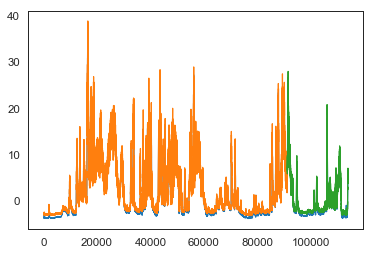

iteration
6
Train on 61065 samples, validate on 30078 samples
Epoch 1/2
61065/61065 [==============================] - 6s 103us/step - loss: 0.0030 - mean_absolute_error: 0.0334 - mean_squared_error: 0.0030 - val_loss: 0.0017 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 2/2
61065/61065 [==============================] - 2s 27us/step - loss: 0.0032 - mean_absolute_error: 0.0353 - mean_squared_error: 0.0032 - val_loss: 3.9663e-04 - val_mean_absolute_error: 0.0140 - val_mean_squared_error: 3.9663e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100)               80400     
_________________________________________________________________
lambda_9 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total p

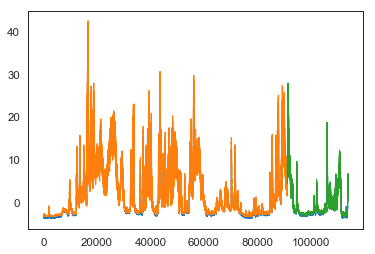

iteration
7
Train on 61065 samples, validate on 30078 samples
Epoch 1/2
61065/61065 [==============================] - 5s 86us/step - loss: 0.0021 - mean_absolute_error: 0.0281 - mean_squared_error: 0.0021 - val_loss: 0.0032 - val_mean_absolute_error: 0.0309 - val_mean_squared_error: 0.0032
Epoch 2/2
61065/61065 [==============================] - 4s 61us/step - loss: 0.0057 - mean_absolute_error: 0.0450 - mean_squared_error: 0.0057 - val_loss: 3.9313e-04 - val_mean_absolute_error: 0.0150 - val_mean_squared_error: 3.9313e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 100)               80400     
_________________________________________________________________
lambda_10 (Lambda)           (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total pa

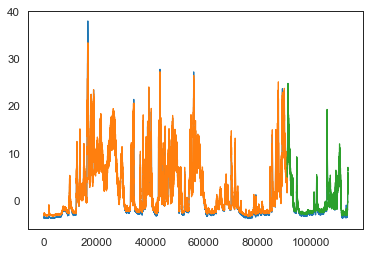

iteration
8
Train on 61065 samples, validate on 30078 samples
Epoch 1/2
61065/61065 [==============================] - 5s 75us/step - loss: 0.0036 - mean_absolute_error: 0.0371 - mean_squared_error: 0.0036 - val_loss: 0.0021 - val_mean_absolute_error: 0.0273 - val_mean_squared_error: 0.0021
Epoch 2/2
61065/61065 [==============================] - 1s 22us/step - loss: 0.0043 - mean_absolute_error: 0.0413 - mean_squared_error: 0.0043 - val_loss: 5.7650e-04 - val_mean_absolute_error: 0.0189 - val_mean_squared_error: 5.7650e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100)               80400     
_________________________________________________________________
lambda_11 (Lambda)           (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total pa

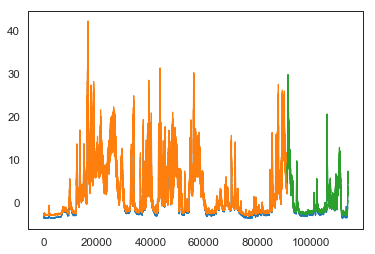

iteration
9
Train on 61065 samples, validate on 30078 samples
Epoch 1/2
61065/61065 [==============================] - 5s 78us/step - loss: 0.0015 - mean_absolute_error: 0.0248 - mean_squared_error: 0.0015 - val_loss: 8.4744e-04 - val_mean_absolute_error: 0.0216 - val_mean_squared_error: 8.4744e-04
Epoch 2/2
61065/61065 [==============================] - 1s 22us/step - loss: 7.5496e-04 - mean_absolute_error: 0.0180 - mean_squared_error: 7.5496e-04 - val_loss: 3.4813e-04 - val_mean_absolute_error: 0.0143 - val_mean_squared_error: 3.4813e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100)               80400     
_________________________________________________________________
lambda_12 (Lambda)           (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101

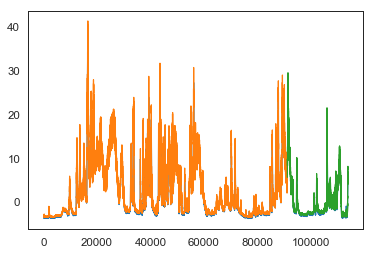

In [22]:
iters = 10

test_results = []
pred_results = []
for x in range(iters):
    print('iteration')
    print(x)
    test,pred,acc = experiment(df)
    test_results.append(test)
    pred_results.append(pred)

In [23]:
# Save out of sample predictions

import xlsxwriter

workbook = xlsxwriter.Workbook('dropout_uncertainty_output_prediction.xlsx')
worksheet = workbook.add_worksheet()


col = 0
for row in range(len(pred_results)):
    for col in range(len(pred_results[row])):
        value = pred_results[row][col][0]
        worksheet.write(col, row,value)

workbook.close()

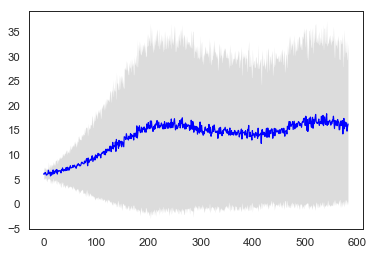

In [24]:
# Plot the uncertainty area

import scipy.stats as st

df2 = pd.read_excel ('dropout_uncertainty_output_prediction.xlsx')
df2 = df2.astype(float)   # Convert string data to float
data2 = df2

res = []
means = []
data2 = data2.T

cols = list(data2.columns) 
for x in range(len(cols)):
    means.append(data2[x].mean())
    res.append(st.t.interval(0.95, len(data2[x])-1, loc=np.mean(data2[x]), scale=st.sem(data2[x])))

low,high = map(list, zip(*res))

fig, ax = plt.subplots()

y = list(range(len(high)))
ax.fill_between(y, high,low, facecolor='grey', alpha=0.27 )
ax.plot(y,means,color = 'blue', label=' uncertainity (noise)')

plt.show()